## The original CNN model as taken from online source

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [44]:
import argparse
import os
import random
import signal
import sys
import uuid
from collections import deque

import cv2
import gym
import gym_donkeycar
import numpy as np
import tensorflow as tf
# from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Conv2D, Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D, GlobalAveragePooling1D, Conv3D
from tensorflow.keras.layers import Input, GlobalAveragePooling3D
from tensorflow.keras.layers import TimeDistributed as TD
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt # debug
# logging
# from stable_baselines import logger
# from stable_baselines.common import explained_variance, tf_util, TensorboardWriter
# from stable_baselines.common.tf_util import mse, total_episode_reward_logger
import math
import datetime
# from imageprocess import detect_edge
img_rows, img_cols = 80, 80
# Convert image into Black and white
img_channels = 4  # We stack 4 frames

In [15]:
class DQNAgent:
    def __init__(self):
        self.learning_rate = 1e-4
    def build_model(self):
        model = Sequential()
        model.add(
            Conv2D(24, (5, 5), strides=(2, 2), padding="same", input_shape=(img_rows, img_cols, img_channels))
        )  # 80*80*4
        model.add(Activation("relu"))
        model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (3, 3), strides=(1, 1), padding="same"))
        model.add(Activation("relu"))
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))

        # 15 categorical bins for Steering angles
        model.add(Dense(15, activation="linear"))

        adam = Adam(lr=self.learning_rate)
        model.compile(loss="mse", optimizer=adam)

        return model

In [16]:
dqn_agent = DQNAgent()
model = dqn_agent.build_model()

In [17]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 40, 40, 24)        2424      
_________________________________________________________________
activation_24 (Activation)   (None, 40, 40, 24)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 20, 20, 32)        19232     
_________________________________________________________________
activation_25 (Activation)   (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
activation_26 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 5, 64)         

## Research on a model of CNN to use in tandem with lane detection
https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist

In [25]:
model = [0] * 8
j=4

model[j] = Sequential()

model[j].add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(80,80,4)))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(32,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))

model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=3,activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Conv2D(64,kernel_size=5,strides=2,padding='same',activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))

model[j].add(Flatten())
model[j].add(Dense(128, activation='relu'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.4))
model[j].add(Dense(15, activation='softmax'))

model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [26]:
model[j].summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 78, 78, 32)        1184      
_________________________________________________________________
batch_normalization_10 (Batc (None, 78, 78, 32)        128       
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 76, 76, 32)        9248      
_________________________________________________________________
batch_normalization_11 (Batc (None, 76, 76, 32)        128       
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 38, 38, 32)        25632     
_________________________________________________________________
batch_normalization_12 (Batc (None, 38, 38, 32)        128       
_________________________________________________________________
dropout_3 (Dropout)          (None, 38, 38, 32)       

## Build my own CNN

In [45]:
class DQNAgent:
    def __init__(self):
        self.learning_rate = 1e-4
    def build_model(self):
        model = Sequential()
        model.add(
            Conv2D(16, (5, 5), strides=(2, 2), padding="same", input_shape=(img_rows, img_cols, img_channels))
        )  # 80*80*4
        model.add(Activation("relu"))
        model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same"))
        model.add(Activation("relu"))
        
        model.add(layers.GlobalAveragePooling2D()) # replace the CNN model with a custom one
        
        model.add(Dense(128))
        model.add(Activation("relu"))

        # 15 categorical bins for Steering angles
        model.add(Dense(15, activation="linear"))

        adam = Adam(lr=self.learning_rate)
        model.compile(loss="mse", optimizer=adam)

        return model

In [46]:
dqn_agent = DQNAgent()
model = dqn_agent.build_model()
model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_71 (Conv2D)           (None, 40, 40, 16)        1616      
_________________________________________________________________
activation_62 (Activation)   (None, 40, 40, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 20, 20, 32)        12832     
_________________________________________________________________
activation_63 (Activation)   (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 10, 10, 64)        51264     
_________________________________________________________________
activation_64 (Activation)   (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 5, 5, 128)       

## Edit 2 to CNN: when images are stacked vertically instead of stacking in the color channel

In [3]:
img_rows, img_cols = 80, 80
# Convert image into Black and white
img_channels = 4  # We stack 4 frames

In [12]:
499967

499967

In [82]:
class DQNAgent:
    def __init__(self):
        self.learning_rate = 1e-4
        self.action_size = 15
        self.color_channels=1
    def build_model(self):
        model = Sequential()
        model.add(Conv2D(16, (5, 5), strides=(2, 2), padding="same", input_shape=(img_rows*img_channels, img_cols, color_channels), activation='relu'))  # 80*80*4
        model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same", activation='relu'))
        model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", activation='relu'))
        model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation='relu'))
        model.add(Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation='relu'))

        model.add(GlobalAveragePooling2D()) # replace the CNN model with a custom one

        model.add(Dense(128, activation='relu'))

        # 15 categorical bins for Steering angles
        model.add(Dense(self.action_size, activation="linear"))

        adam = Adam(lr=self.learning_rate)
        model.compile(loss="mse", optimizer=adam)
        
        return model

In [83]:
dqn_agent = DQNAgent()
model = dqn_agent.build_model()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 160, 40, 16)       416       
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 80, 20, 32)        12832     
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 40, 10, 64)        51264     
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 20, 5, 128)        73856     
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 20, 5, 256)        295168    
_________________________________________________________________
global_average_pooling2d_10  (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)             

In [26]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image

In [54]:
next_obs = cv2.imread("images/0_cam-image_array_.jpg")
x_t = next_obs[:, :, 0]
x_t.shape

(120, 160)

In [69]:
x_t = cv2.resize(x_t, (80, 80))

In [70]:
img_rows, img_col = x_t.shape

In [71]:
img_channels = 4
s_t = np.vstack((x_t,)*img_channels) # 4*80*80
s_t.shape

(320, 80)

In [72]:
s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], color_channels)  # 1*320*80*1
s_t.shape

(1, 320, 80, 1)

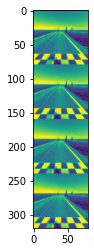

In [74]:
plt.imshow(s_t[0])

In [75]:
next_obs = cv2.imread("images/1283_cam-image_array_.jpg")
x_t1 = next_obs[:, :, 0]
x_t1.shape

(120, 160)

In [76]:
x_t1 = cv2.resize(x_t1, (80, 80))

In [77]:
color_channels = 1
x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], color_channels)  # 1x80x80x1

In [78]:
s_t[:, img_rows:, :, :].shape

(1, 240, 80, 1)

In [79]:
s_t1 = np.append(x_t1, s_t[:, img_rows:, :, :], axis=1)  # 1x320x80x4
s_t1.shape

(1, 320, 80, 1)

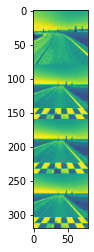

In [80]:
plt.imshow(s_t1[0])

In [84]:
model(s_t1)

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[ 0.21673009, -3.4038894 , -1.6912638 ,  1.470401  , -1.1312703 ,
        -0.9440307 ,  3.268939  ,  2.7457528 , -2.42553   ,  1.223944  ,
        -2.5801084 , -0.9476988 ,  0.5892639 ,  2.4082983 ,  2.1118782 ]],
      dtype=float32)>

## Edit 3: Use TD layers to be consistent with CNN_LSTM

In [3]:
img_rows, img_cols = 80, 80
# Convert image into Black and white
img_channels = 4  # We stack 4 frames

In [40]:
class DQNAgent:
    def __init__(self):
        self.learning_rate = 1e-4
        self.action_size = 15
        self.color_channels=1
    def build_model(self):
        model = Sequential()
        model.add(Input(shape = (img_channels, img_rows, img_cols, color_channels), name="img_in"))
        model.add(TD(Conv2D(16, (5, 5), strides=(2, 2), padding="same", activation='relu')))  # 80*80*4
        model.add(TD(Conv2D(32, (5, 5), strides=(2, 2), padding="same", activation='relu')))
        model.add(TD(Conv2D(64, (5, 5), strides=(2, 2), padding="same", activation='relu')))
        model.add(TD(Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation='relu')))
        model.add(TD(Conv2D(256, (3, 3), strides=(1, 1), padding="same", activation='relu')))

        model.add(TD(GlobalAveragePooling2D())) # replace the CNN model with a custom one
        model.add(Flatten())
#         model.add(GlobalAveragePooling1D())
        model.add(Dense(128, activation='relu'))

        # 15 categorical bins for Steering angles
        model.add(Dense(self.action_size, activation="linear"))

        adam = Adam(lr=self.learning_rate)
        model.compile(loss="mse", optimizer=adam)
        
        return model

In [41]:
dqn_agent = DQNAgent()
model = dqn_agent.build_model()
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_45 (TimeDis (None, 4, 40, 40, 16)     416       
_________________________________________________________________
time_distributed_46 (TimeDis (None, 4, 20, 20, 32)     12832     
_________________________________________________________________
time_distributed_47 (TimeDis (None, 4, 10, 10, 64)     51264     
_________________________________________________________________
time_distributed_48 (TimeDis (None, 4, 5, 5, 128)      73856     
_________________________________________________________________
time_distributed_49 (TimeDis (None, 4, 5, 5, 256)      295168    
_________________________________________________________________
time_distributed_50 (TimeDis (None, 4, 256)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)            

In [26]:
img_rows = 80
img_cols = 80
img_channels = 4
def rgb2gray(rgb):
    """
    take a numpy rgb image return a new single channel image converted to greyscale
    """
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def process_image(obs):
    global LANE_SEGMENTATION 
    obs = rgb2gray(obs)
    obs = cv2.resize(obs, (img_rows, img_cols))
#         print("in process_image") # debug 
#         plt.imshow(obs) # debug
#     if LANE_SEGMENTATION: obs = detect_edge(obs)
    return obs

In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from PIL import Image

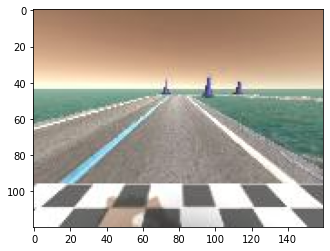

In [29]:
next_obs = cv2.imread("images/0_cam-image_array_.jpg")
plt.imshow(next_obs)

In [30]:
x_t = process_image(next_obs)
s_t = np.stack((x_t,)*img_channels, axis=0) # 4*80*80
# In Keras, need to reshape 
s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2], 1)  # 1*4*80*80*1
s_t.shape

(1, 4, 80, 80, 1)

In [31]:
model(s_t)

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[ 0.94708204, -1.0664704 , -3.6177099 , -1.8555422 ,  4.749403  ,
         2.1198473 , -3.563586  , -0.8610939 , -1.0865867 ,  2.4440231 ,
         1.403626  ,  0.22701192,  2.3279645 ,  4.143304  , -3.4766247 ]],
      dtype=float32)>

In [32]:
next_obs = cv2.imread("images/1283_cam-image_array_.jpg")
# plt.imshow(agent.process_image(next_obs)) # debug
# plt.savefig("{}.png".format(agent.t)) # debug
x_t1 = process_image(next_obs)
x_t1 = x_t1.reshape(1, 1, x_t1.shape[0], x_t1.shape[1], color_channels)  # 1x1x80x80x(num_color)
s_t1 = np.append(s_t[:, 1:, :, :], x_t1, axis=1)  # 1x4x80x80x(num_color)
print("x_t1 shape:", x_t1.shape)
print("s_t1 shape:", s_t1.shape)

x_t1 shape: (1, 1, 80, 80, 1)
s_t1 shape: (1, 4, 80, 80, 1)


In [33]:
model(s_t1)

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[ 0.94225883, -0.97773796, -3.4080276 , -1.7993137 ,  4.6807213 ,
         2.0968292 , -3.629108  , -0.7741537 , -1.0806696 ,  2.3456426 ,
         1.4334505 ,  0.11540532,  2.214334  ,  4.275386  , -3.4695284 ]],
      dtype=float32)>

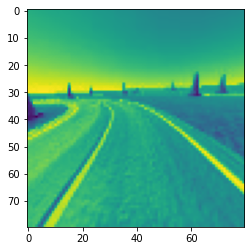

In [34]:
plt.imshow(s_t1[0, 3, :, :])

## Edit4: use of Conv3D

In [84]:
class DQNAgent:
    def __init__(self):
        self.learning_rate = 1e-4
        self.action_size = 15
    def build_model(self, seq_length=4, num_outputs=15, input_shape=(80, 80)):
        img_seq_shape = (seq_length,) + input_shape + (1,)

        model = Sequential()
        model.add(Input(shape=img_seq_shape, name='img_in')) # 4*80*80*1
        model.add(Conv3D(16, (3, 5, 5), strides=(1, 2, 2), padding="same", activation='relu'))
        model.add(Conv3D(32, (3, 5, 5), strides=(1, 2, 2), padding="same", activation='relu'))
        model.add(Conv3D(64, (1, 5, 5), strides=(1, 2, 2), padding="same", activation='relu'))
        model.add(Conv3D(128, (1, 3, 3), strides=(1, 2, 2), padding="same", activation='relu'))
        model.add(Conv3D(256, (1, 3, 3), strides=(1, 1, 1), padding="same", activation='relu'))
        
#         model.add(TD(GlobalAveragePooling2D()))
        model.add(GlobalAveragePooling3D())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(self.action_size, activation='linear', name='model_outputs'))

        adam = Adam(lr=self.learning_rate)
        model.compile(loss="mse", optimizer=adam)


        return model

In [85]:
dqn_agent = DQNAgent()
model = dqn_agent.build_model()
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_94 (Conv3D)           (None, 4, 40, 40, 16)     1216      
_________________________________________________________________
conv3d_95 (Conv3D)           (None, 4, 20, 20, 32)     38432     
_________________________________________________________________
conv3d_96 (Conv3D)           (None, 4, 10, 10, 64)     51264     
_________________________________________________________________
conv3d_97 (Conv3D)           (None, 4, 5, 5, 128)      73856     
_________________________________________________________________
conv3d_98 (Conv3D)           (None, 4, 5, 5, 256)      295168    
_________________________________________________________________
global_average_pooling3d (Gl (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)             

In [83]:
model(s_t)

<tf.Tensor: shape=(1, 15), dtype=float32, numpy=
array([[-5.515965  , -0.7883996 ,  4.0691004 , -2.4967778 ,  1.6798246 ,
        -3.0059478 , -1.8017204 , -2.4801533 , -8.128548  , -4.7342014 ,
        -2.489071  , -0.66128063, -6.8953986 , -3.1828392 , -6.3743367 ]],
      dtype=float32)>